In [43]:
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # 특정 GPU에 1GB 메모리만 할당하도록 제한
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=10000)])
    except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
        print(e)

In [44]:
# 사진별로 번호 멕이기

#csv
import pandas as pd

category_csv = pd.read_csv('../data/category3.csv')
label_dict = dict(category_csv[['bottle_name', 'bottle_id']].values)
print(label_dict)

{'banchan': 0, 'beer': 1, 'beji': 2, 'beji_t': 3, 'bottle': 4, 'bottle_t': 5, 'empty': 6, 'glass': 7, 'glass_t': 8, 'me': 9, 'me_t': 10, 'perfume': 11, 'soju': 12, 'vita': 13, 'wine': 14, 'wine_t': 15}


In [93]:
#HSV 함수

import cv2
def my_func(frame):
    return cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

In [45]:
#이미지 불러오기

import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

rootPath = '../data/image3/'

with tf.device('/device:GPU:0'):

    train_imageGenerator = ImageDataGenerator(
#         preprocessing_function = my_func,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
#         zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        validation_split=.2
    )
    
    val_imageGenerator = ImageDataGenerator(
#         preprocessing_function = my_func,
        rescale=1./255,
        validation_split=.2
    )
    # 이미지 불러옴
    trainGen = train_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='training',
        batch_size = 30,
        class_mode="sparse"
    )

    validationGen = val_imageGenerator.flow_from_directory(
        rootPath,
        target_size=(224, 224),
        classes=label_dict,
        subset='validation',
        batch_size = 30,
        class_mode="sparse"
    )

Found 623 images belonging to 16 classes.
Found 147 images belonging to 16 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224, 3)


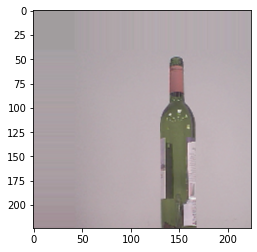

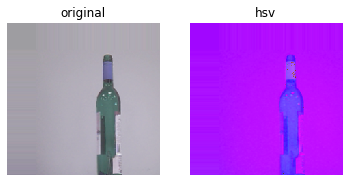

In [37]:
# HSV 확인하기

x, y = trainGen.next()

# print(x[0])

import matplotlib.pyplot as plt

plt.imshow(x[0])

import cv2
import numpy as np

frame = x[0]


# Convert BGR to HSV
hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)
# hsv = cv2.cvtColor(frame, cv2.COLOR_RGB2HSV)

print(hsv.shape)

# plt.imshow(hsv)

# define range of blue color in HSV
lower_blue = np.array([40,10,0])
upper_blue = np.array([70,30,2])

# Threshold the HSV image to get only blue colors
mask = cv2.inRange(hsv, lower_blue, upper_blue)

# plt.imshow(mask)



# Bitwise-AND mask and original image
res = cv2.bitwise_and(frame,frame, mask= mask)

# plt.imshow(res)




fig = plt.figure()
rows = 1
cols = 2
 
ax1 = fig.add_subplot(rows, cols, 1)
ax1.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
ax1.set_title('original')
ax1.axis("off")

ax1 = fig.add_subplot(rows, cols, 2)
ax1.imshow(cv2.cvtColor(hsv, cv2.COLOR_BGR2RGB))
ax1.set_title('hsv')
ax1.axis("off")
 
# ax2 = fig.add_subplot(rows, cols, 3)
# ax2.imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
# ax2.set_title('mask')
# ax2.axis("off")
 
plt.show()






In [47]:
# CNN

import tensorflow as tf
import matplotlib.pyplot as plt
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

rootPath = '../data/image3/'

def get_lr_callback():
    lr_start   = 0.00001*10*0.5
    lr_max     = 0.0000005 * 10 * 10*0.5
    lr_min     = 0.000001 * 10*0.5
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
     
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback

with tf.device('/device:GPU:0'):
    
    model = Sequential()
    
    model.add(Conv2D(filters=256,
                     kernel_size=(3,3),
                     activation='relu',
                    input_shape=(224,224,3))) 
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=512,
                     kernel_size=(3,3),
                     activation='relu')) 
    model.add(MaxPool2D(pool_size=(2,2)))
    
    model.add(Conv2D(filters=256,
                     kernel_size=(3,3),
                     activation='relu',)) 
    model.add(MaxPool2D(pool_size=(2,2)))

    # 여기까지 Convolusion Layer
    
    
    model.add(GlobalAveragePooling2D())

    model.add(Dense(units=256,
                    activation='relu'))
    
    model.add(Dense(units=16,
                    activation='softmax'))
    # 여기까지 FC Layer
#     print(model.summay())

    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
            # Model saving callback
    checkpointer = ModelCheckpoint(filepath='../model/recycle_cnn_1218.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)   

    
    history = model.fit(trainGen,
                        callbacks=[checkpointer, early_stopping, get_lr_callback()],
                        steps_per_epoch=21,
                        epochs=250,
                        validation_data=validationGen,
                        validation_steps=5)


  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/250
20/21 [===========================>..] - ETA: 0s - loss: 2.7186 - sparse_categorical_accuracy: 0.1400
Epoch 00001: val_loss improved from inf to 2.65981, saving model to ../model/recycle_cnn_1218.h5
21/21 [==============================] - 13s 625ms/step - loss: 2.7187 - sparse_categorical_accuracy: 0.1396 - val_loss: 2.6598 - val_sparse_categorical_accuracy: 0.1429
Epoch 2/250
20/21 [===========================>..] - ETA: 0s - loss: 2.6413 - sparse_categorical_accuracy: 0.1433
Epoch 00002: val_loss improved from 2.65981 to 2.62071, saving model to ../model/recycle_cnn_1218.h5
21/21 [==============================] - 13s 636ms/step - loss: 2.6465 - sparse_categorical_accuracy: 0.1396 - val_loss: 2.6207 - val_sparse_categorical_accuracy: 0.1429
Epoch 3/250
20/21 [===========================>..] - ETA: 0s - loss: 2.6340 - sparse_categorical_accuracy: 0.1349
Epoch 00003: val_loss improve

Epoch 22/250
20/21 [===========================>..] - ETA: 0s - loss: 2.6082 - sparse_categorical_accuracy: 0.1804
Epoch 00022: val_loss improved from 2.60191 to 2.60139, saving model to ../model/recycle_cnn_1218.h5
21/21 [==============================] - 13s 606ms/step - loss: 2.6126 - sparse_categorical_accuracy: 0.1814 - val_loss: 2.6014 - val_sparse_categorical_accuracy: 0.2721
Epoch 23/250
20/21 [===========================>..] - ETA: 0s - loss: 2.6168 - sparse_categorical_accuracy: 0.2462
Epoch 00023: val_loss did not improve from 2.60139
21/21 [==============================] - 13s 604ms/step - loss: 2.6107 - sparse_categorical_accuracy: 0.2424 - val_loss: 2.6016 - val_sparse_categorical_accuracy: 0.1429
Epoch 24/250
20/21 [===========================>..] - ETA: 0s - loss: 2.6185 - sparse_categorical_accuracy: 0.1400
Epoch 00024: val_loss improved from 2.60139 to 2.60087, saving model to ../model/recycle_cnn_1218.h5
21/21 [==============================] - 13s 602ms/step - loss

Epoch 44/250
20/21 [===========================>..] - ETA: 0s - loss: 2.5967 - sparse_categorical_accuracy: 0.2293
Epoch 00044: val_loss improved from 2.58380 to 2.58237, saving model to ../model/recycle_cnn_1218.h5
21/21 [==============================] - 13s 604ms/step - loss: 2.5953 - sparse_categorical_accuracy: 0.2360 - val_loss: 2.5824 - val_sparse_categorical_accuracy: 0.2517
Epoch 45/250
20/21 [===========================>..] - ETA: 0s - loss: 2.5908 - sparse_categorical_accuracy: 0.2159
Epoch 00045: val_loss improved from 2.58237 to 2.58131, saving model to ../model/recycle_cnn_1218.h5
21/21 [==============================] - 13s 606ms/step - loss: 2.5937 - sparse_categorical_accuracy: 0.2167 - val_loss: 2.5813 - val_sparse_categorical_accuracy: 0.2313
Epoch 46/250
 3/21 [===>..........................] - ETA: 11s - loss: 2.5593 - sparse_categorical_accuracy: 0.3000WARNING:tensorflow:Can save best model only with val_loss available, skipping.


KeyboardInterrupt: 

In [48]:
# Densenet201

import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop, Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


rootPath = '../data/image3/'

def get_lr_callback():
    lr_start   = 0.00001*10*0.5
    lr_max     = 0.0000005 * 10 * 10*0.5
    lr_min     = 0.000001 * 10*0.5
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
     
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start   
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max    
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min    
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = False)
    return lr_callback


## Pretrained Network
with tf.device('/device:GPU:0'):
    model_base = DenseNet201(weights='imagenet',
                       include_top=False,
                       input_shape=(224,224,3))

    model_base.trainable = True  # Convolution Layer 완전 동결

    model = Sequential()

    model.add(model_base)

    model.add(GlobalAveragePooling2D())

    model.add(Dense(256,
                    activation='relu'))
#     model.add(BatchNormalization())
    model.add(Dense(16,
                    activation='softmax'))

    model.summary()

    model.compile(optimizer=RMSprop(learning_rate=1e-5),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])
    
   
    
    
        # Model saving callback
    checkpointer = ModelCheckpoint(filepath='../model/recycle_cnn_1218.h5', monitor='val_loss', verbose=1, save_best_only=True)

#     Early stopping
    early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=20)

    history = model.fit(trainGen,
                        callbacks=[checkpointer, early_stopping, get_lr_callback()],
                        steps_per_epoch=21,
                        epochs=250,
                        validation_data=validationGen,
                        validation_steps=5,
                        verbose=2)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet201 (Model)          (None, 7, 7, 1920)        18321984  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 1920)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               491776    
_________________________________________________________________
dense_5 (Dense)              (None, 16)                4112      
Total params: 18,817,872
Trainable params: 18,588,816
Non-trainable params: 229,056
_________________________________________________________________
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 21 steps, validate for 5 steps
Epoch 1/250

Epoch 00001: val_loss improved from inf to 1.63760, saving model to ../model/recycle_cnn_1218.h5
21/21 - 60s - loss: 1.5477 - spar

Epoch 34/250

Epoch 00034: val_loss did not improve from 0.07648
21/21 - 13s - loss: 0.0020 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.0796 - val_sparse_categorical_accuracy: 0.9660
Epoch 35/250

Epoch 00035: val_loss did not improve from 0.07648
21/21 - 13s - loss: 0.0012 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1104 - val_sparse_categorical_accuracy: 0.9456
Epoch 36/250

Epoch 00036: val_loss did not improve from 0.07648
21/21 - 13s - loss: 0.0012 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1092 - val_sparse_categorical_accuracy: 0.9456
Epoch 37/250

Epoch 00037: val_loss did not improve from 0.07648
21/21 - 13s - loss: 0.0015 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1013 - val_sparse_categorical_accuracy: 0.9524
Epoch 38/250

Epoch 00038: val_loss did not improve from 0.07648
21/21 - 13s - loss: 0.0010 - sparse_categorical_accuracy: 1.0000 - val_loss: 0.1520 - val_sparse_categorical_accuracy: 0.9388
Epoch 39/250

Epoch 00039: val_loss did not i

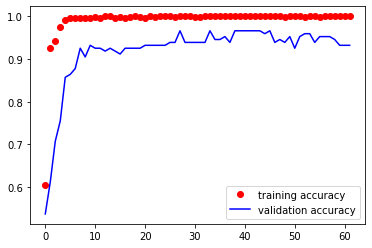

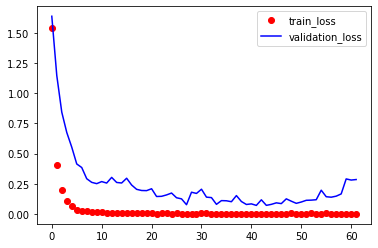

In [49]:
%matplotlib inline

import matplotlib.pyplot as plt

train_acc = history.history['sparse_categorical_accuracy']
val_acc = history.history['val_sparse_categorical_accuracy']

train_loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(train_acc,'bo', color='r', label='training accuracy')
plt.plot(val_acc,'b', color='b', label='validation accuracy')
plt.legend()
plt.show()

plt.plot(train_loss,'bo', color='r', label='train_loss')
plt.plot(val_loss,'b', color='b', label='validation_loss')
plt.legend()
plt.show()

[12. 13.  7. 13. 11.  4.  5. 12.  6.  4.  8.  3.  9.  5.  7.  7.  2.  7.
  7.  4. 13. 11. 11.  4. 10.  1. 13.]
[1.8117660e-06 7.0856026e-06 4.2959427e-06 5.8907935e-06 7.5491480e-06
 1.4877145e-05 3.6904903e-06 2.0356795e-06 8.1211232e-07 6.7682909e-06
 2.5931397e-06 2.8095312e-05 6.2020570e-07 9.9990189e-01 7.8031699e-06
 4.2050165e-06]
Confusion Matrix
[12 13  7 13 11  4  5 12  6  4  8  3  9  5  7  7  2  7  7  4 13 11 11  4
 10  1 13]


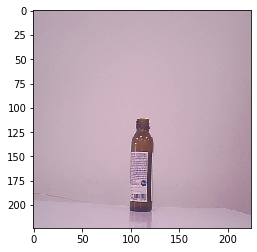

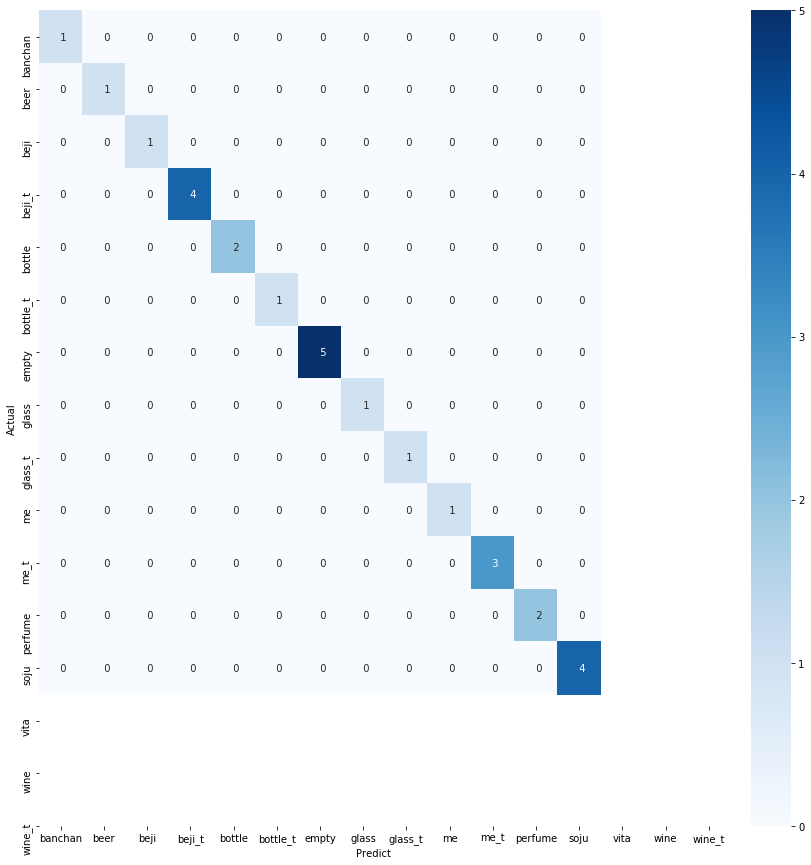

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns 
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

with tf.device('/device:GPU:0'):


#     model_path = '../model/recycle_VGG16_image3_1217.h5'

    model_path = '../model/recycle_cnn_1218.h5'


    vgg_model = tf.keras.models.load_model(model_path)


    x_train, y_train= validationGen.next()
    print(y_train)
    plt.imshow(x_train[1])

    #Confution Matrix and Classification Report
    Y_pred = vgg_model.predict(x_train)
    
    print(Y_pred[1])

    y_pred = np.argmax(Y_pred, axis=1)


    print('Confusion Matrix')
    # display(confusion_matrix(validationGen.classes, y_pred))

    print(y_pred)





    fig, ax = plt.subplots(figsize=(15,15))  # inch단위로 그림의 크기
    sns.heatmap(
        confusion_matrix(y_train, y_pred),
        annot = True, # 숫자표현
        fmt = '3d',    # 정수표현     
        cmap = 'Blues', # color 색상
        ax = ax,       # 그래프로 사용할 subplot
        xticklabels=category_csv['bottle_name'], 
        yticklabels=category_csv['bottle_name']
    )
    ax.set_xlabel('Predict')
    ax.set_ylabel('Actual')
    plt.show()